In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import random
random.seed(2024)
from typing import List, Union, Dict, Tuple
from tqdm.autonotebook import trange
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer
from datasets import load_dataset

C:\Users\clw20\AppData\Local\Temp\ipykernel_10540\4086870200.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
def _text_length(text: Union[List[int], List[List[int]]]):
    if isinstance(text, dict):  # {key: value} case
        return len(next(iter(text.values())))
    elif not hasattr(text, "__len__"):  # Object has no len() method
        return 1
    elif len(text) == 0 or isinstance(text[0], int):  # Empty string or list of ints
        return len(text)
    else:
        return sum([len(t) for t in text])  # Sum of length of individual strings
    
def inference(tokenizer: AutoTokenizer, model: ORTModelForFeatureExtraction, 
             sentences: List[str], batch_size:int = 16, verbose: bool =False):
    
    length_sorted_idx = np.argsort([-_text_length(sen) for sen in sentences])
    sentences_sorted = [sentences[idx] for idx in length_sorted_idx]

    embeddings = []

    with tqdm(total=len(sentences), desc="Batches", disable = not verbose) as pbar:
        for i in trange(0, len(sentences), batch_size, desc="Batches", disable = True):
            batch = sentences_sorted[i:i+batch_size]
            encoded_inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(torch.device('cpu'))
            with torch.no_grad():
                output = model(**encoded_inputs)['last_hidden_state'].detach()
                batch_prototypes = torch.mean(output, dim=1)
                batch_prototypes = torch.nn.functional.normalize(batch_prototypes, p=2, dim=1).to(torch.device('cpu'))
                embeddings.extend(batch_prototypes)
            pbar.update(len(batch))

    embeddings = [embeddings[idx] for idx in np.argsort(length_sorted_idx)]
    embeddings = np.asarray([emb.numpy() for emb in embeddings])

    return embeddings

In [3]:
category_dataset = "clw8998/Shopee-Categories"
p_name_dataset = 'clw8998/Coupang-Product-Set-1M'
model_id = 'clw8998/Product-Classification-Model-Distilled'
batch_size = 16
model = ORTModelForFeatureExtraction.from_pretrained(model_id, export=False)
tokenizer = AutoTokenizer.from_pretrained(model_id)

categories = load_dataset(category_dataset, split="train")['category']
p_names = load_dataset(p_name_dataset, split="train")['product_name']

# replace your Start, End here
# p_names = p_names[start: end]
p_names = random.sample(p_names, 10)

In [4]:
print(f"Num of category: {len(categories)}, Num of p_name: {len(p_names)}")

Num of category: 1425, Num of p_name: 10


In [5]:
def get_category(tokenizer: AutoTokenizer, model: ORTModelForFeatureExtraction, 
                 p_names: List[str], categories: List[str], top_k: int = 3) -> Dict[str, List[Tuple[str, float]]]:

    p_names_embeddings = inference(tokenizer, model, p_names, batch_size, verbose=True)  # (n, 768)
    categories_embeddings = inference(tokenizer, model, categories, batch_size, verbose=True)  # (m, 768)
    scores_matrix = np.dot(p_names_embeddings, categories_embeddings.T)  # (n, m)
    
    result = {}
    for i in range(len(p_names)):
        top_k_indices = np.argsort(-scores_matrix[i])[:top_k]
        top_k_with_scores = [(categories[index], scores_matrix[i][index]) for index in top_k_indices]
        result[p_names[i]] = top_k_with_scores

    return result


In [6]:
top_k = 3
result = get_category(tokenizer, model, p_names, categories, top_k=top_k)

Batches: 100%|██████████| 1425/1425 [00:09<00:00, 151.41it/s]


In [7]:
df = pd.DataFrame.from_dict(result, orient='index')
df_expanded = pd.DataFrame(
    df.apply(lambda x: pd.Series([item for sublist in x for item in sublist]), axis=1)
)

columns = []
for i in range(top_k):
    columns.append(f'category_{i+1}')
    columns.append(f'score_{i+1}')

df_expanded.columns = columns
df_expanded = df_expanded.reset_index().rename(columns={'index': 'p_name'})
df_expanded[['class_1', 'class_2', 'class_3']] = df_expanded['category_1'].apply(lambda x: pd.Series(x.split('_'))[:3])
cols = df_expanded.columns.tolist()
new_order = ['p_name', 'class_1', 'class_2', 'class_3', 'category_1'] + cols[2:]

df_expanded = df_expanded[new_order]
df_expanded = df_expanded.loc[:, ~df_expanded.columns.duplicated()]

# df_expanded.to_csv('你的學號_categories.csv', index=False, encoding='utf-8-sig')
df_expanded

,p_name,class_1,class_2,class_3,category_1,score_1,category_2,score_2,category_3,score_3
0,"NS_象牙強化 11吋(櫻花)義大利大圓皿 S001 D5, 1入",文創商品,設計雜物,花瓶,文創商品_設計雜物_花瓶,0.474916,居家生活_餐廚_碗盤器皿,0.470140,居家生活_園藝植作_園藝裝飾,0.422154
1,"StazOn MIDI 郵票油性印台 SZM-63, 茶藍, 1個",文創商品,文具,印章墨水、印章、印泥,文創商品_文具_印章墨水、印章、印泥,0.514809,居家生活_文具_印章墨水、印章、印泥,0.510279,娛樂、收藏_其他_相簿,0.502358
2,KARAS MacBook Pro Retina Touch Bar 13.3 MR9V2K...,3C與筆電,其他,NaN,3C與筆電_其他,0.749731,3C與筆電_筆記型電腦,0.728732,3C與筆電_電腦周邊配件_電腦/筆電周邊配件 / 其他,0.719396
3,"GGOOMIM 兔子與小熊圖案無痕裝飾玻璃門貼, 混色",娛樂、收藏,收藏、紀念品,壁貼、窗貼,娛樂、收藏_收藏、紀念品_壁貼、窗貼,0.846706,居家生活_居家裝飾_壁貼、窗貼,0.815345,居家生活_居家裝飾_相框、牆壁裝飾,0.652514
4,"DANCING TEA 舞間茶心 爆米花 四季春茶, 60g, 5包",美食、伴手禮,進口零食,爆米花,美食、伴手禮_進口零食_爆米花,0.876530,美食、伴手禮_烘焙食材、南北雜貨_香料,0.442225,美食、伴手禮_休閒零食_乾貨零食 / 其他,0.441599
5,"Power Action 除霉清潔劑, 150ml, 5個",居家生活,日用品,家用清潔劑,居家生活_日用品_家用清潔劑,0.625270,美妝保健_專櫃清潔保養_其他,0.600160,美妝保健_身體清潔、保養_身體除臭劑,0.562690
6,"可愛之家冰箱貼, 4",家電影音,大型家電,冰箱,家電影音_大型家電_冰箱,0.632120,娛樂、收藏_收藏、紀念品_壁貼、窗貼,0.518973,居家生活_居家裝飾_壁貼、窗貼,0.490460
7,"I'M MEME 我愛奶霜柔霧唇釉, 2.8g, 5支, 06 Berry Pink",美妝保健,專櫃彩妝,唇釉,美妝保健_專櫃彩妝_唇釉,0.955832,美妝保健_開架流行彩妝_唇釉,0.954587,美妝保健_專櫃彩妝_口紅、唇膏,0.672848
8,多功能旅行用透明化妝包,美妝保健,美容工具,化妝包,美妝保健_美容工具_化妝包,0.870717,文創商品_設計雜物_旅行包,0.788827,女生包包/精品_名牌精品包_手提包,0.721590
9,Angel In Bedding 蓬鬆防塵超細纖維寢具組,居家生活,寢具,其他,居家生活_寢具_其他,0.742891,居家生活_寢具_床單、枕套、居家睡袋,0.555833,居家生活_寢具_傢俱,0.534884


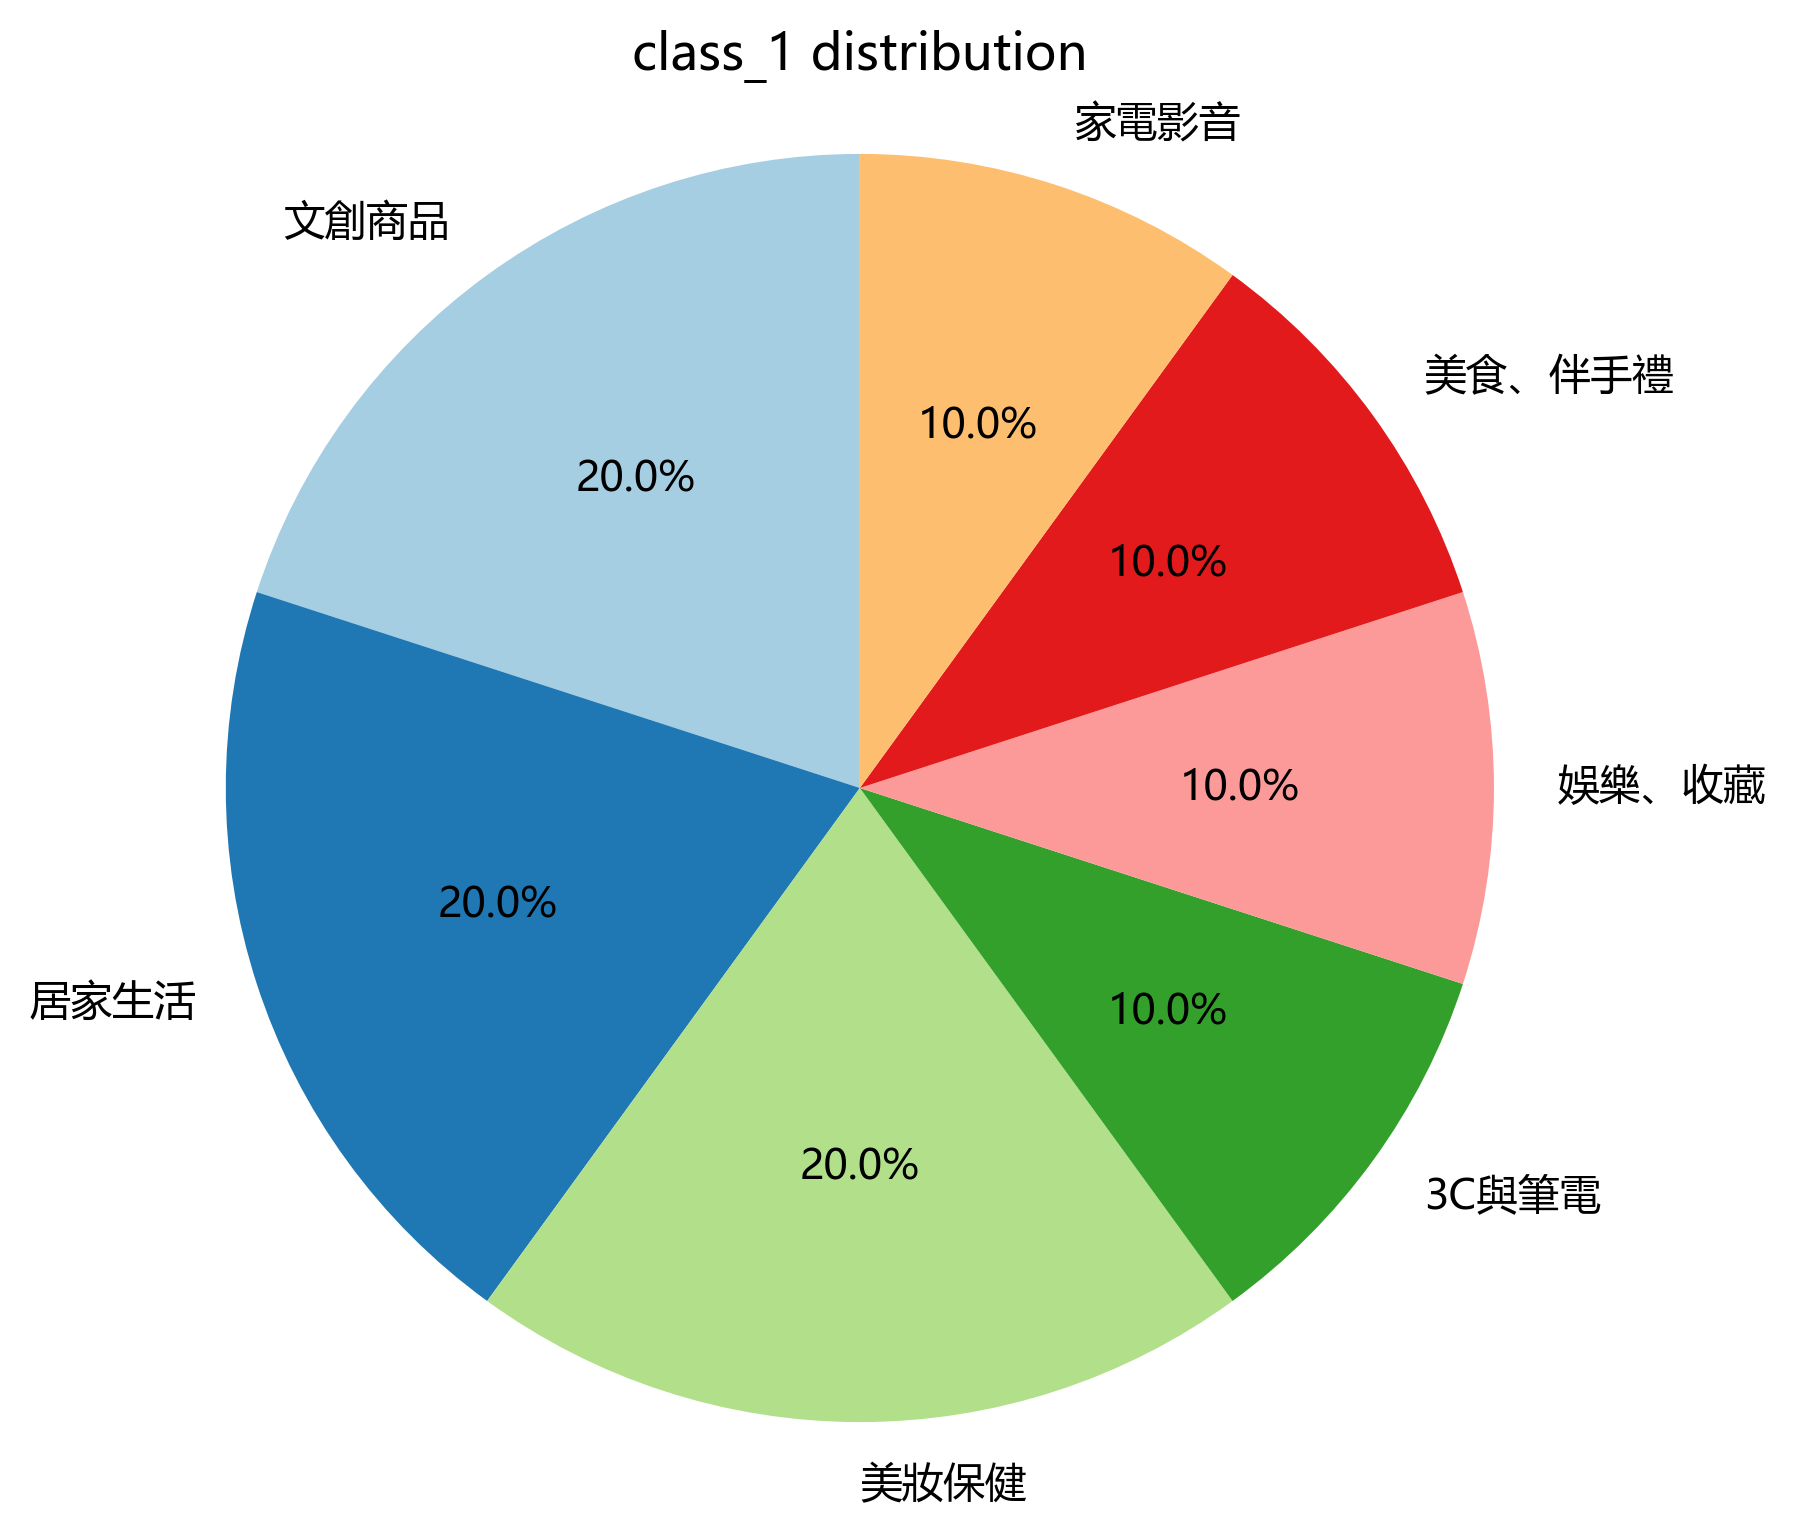

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

class_1_distribution = df_expanded['class_1'].value_counts()

plt.figure(figsize=(6, 6), dpi=300)
plt.pie(class_1_distribution, labels=class_1_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('class_1 distribution')
plt.axis('equal')
# plt.savefig('你的學號_distribution.png', dpi=300) 
plt.show()